# Box-Jenkins法とその周辺

## 概要
### 時系列データを効率的に分析するためのフレームワーク

1. データを分析しやすくなるように変換する
  - 分析しやすい定常過程の特徴を学ぶ
  - データを定常過程に変換する方法を学ぶ
2. データにARIMAモデルやそれに準ずるモデルを適用する
  - ARIMAモデルやその発展形の仕組を学ぶ
  - モデルの同定の手順を学ぶ
3. 推定されたモデルを評価する
  - モデルの適合性の評価の方法を学ぶ
4. 推定されたモデルを用いて予測する
  - モデルの予測精度の評価の方法を学ぶ
  
#### メリット
- 分析のための手順・ルールが整備されており，自動化しやすい

#### デメリット
- ルールに縛られた分析となり，自由な分析はしにくい
- ASRIMAモデルの解釈がやや困難

わりと古典的な手法

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


> https://logics-of-blue.com/python-time-series-analysis/

---
1部の内容も踏まえて軽くおさらい

In [2]:
df = pd.read_csv("AirPassengers.csv")
df["Month"] = pd.to_datetime(df["Month"])
df.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


[1.         0.94804734 0.87557484 0.80668116 0.75262542 0.71376997
 0.6817336  0.66290439 0.65561048 0.67094833 0.70271992 0.74324019
 0.76039504 0.71266087 0.64634228 0.58592342 0.53795519 0.49974753
 0.46873401 0.44987066 0.4416288  0.45722376 0.48248203 0.51712699
 0.53218983 0.49397569 0.43772134 0.3876029  0.34802503 0.31498388
 0.28849682 0.27080187 0.26429011 0.27679934 0.2985215  0.32558712
 0.3370236  0.30333486 0.25397708 0.21065534 0.17217092]


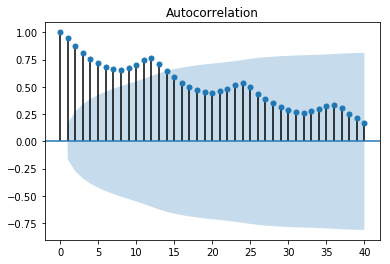

In [3]:
# 自己相関を求める
# http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.acf.html
# http://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html
ts_acf = sm.tsa.stattools.acf(df["#Passengers"],nlags=40)
print(ts_acf)
sm.graphics.tsa.plot_acf(df["#Passengers"], lags=40)
plt.show()

/usr/local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


[ 1.00000000e+00  9.54677042e-01 -2.65277317e-01  5.54695472e-02
  1.08856215e-01  8.11257853e-02  4.12540544e-03  1.56169553e-01
  1.03708330e-01  2.88781439e-01  2.06918048e-01  2.41129704e-01
 -1.58004984e-01 -7.18324604e-01 -8.94806410e-02  2.21605913e-01
  1.34622533e-01  1.15615719e-01  1.94829396e-01  9.66561845e-02
 -2.02158680e-01 -9.36381005e-02 -3.45594572e-01 -1.06170206e-01
  2.77804723e-01  5.87815922e-02  9.86624045e-03  2.37687367e-01
  9.40568218e-02 -1.47505422e-01 -1.88609051e-01 -2.52801158e-01
 -2.57153789e-01 -1.40349613e-01  1.88263087e-01  1.30686258e-01
  5.23902189e-01  6.91426442e-01  9.91163921e-01  3.71021065e+01
 -8.85334119e-01]


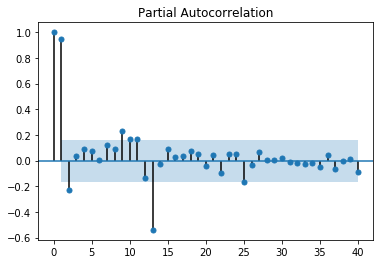

In [4]:
# 偏自己相関を求める
# http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.pacf.html
# http://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_process.ArmaProcess.pacf.html
ts_acf = sm.tsa.stattools.pacf(df["#Passengers"],nlags=40)
print(ts_acf)
sm.graphics.tsa.plot_pacf(df["#Passengers"], lags=40)
plt.show()

- このデータは，1日前と正の自己相関，13日前と負の自己相関が見られる

## 定常過程とデータの変換
### 定常性
- 定常性を持つデータ系列を定常時系列と呼ぶ
- 定常過程は，任意の$t,k$に対して以下が成立する

$E(y_t) = \mu$

$Cov(y_t, y_{t-k}) = E[(y_t-\mu)(y_{t-k}-\mu]=\gamma_k$

- 期待値は時点によらず一定
- 自己共分散(もちろん自己相関も)時点によらず，時間差のみに依存
  - $k=0$のときの共分散が分散と等しくなることから，分散の値も時点によらず一定
- **簡単に言うと，データの水準やばらつき，自己相関の関係が時点によらず一定であるデータ**
  - 2000/1/1と2000/1/2の気温の自己相関と，2010/3/4と2010/3/5の気温の自己相関の強さは同じ
  - ホワイトノイズは期待値が常に0で自己相関も常に0で一定であるため，定常過程と言える

- 「無数に存在する2000/1/1」という日の気温の特徴を，「手元にあるたった1つの2000/1/1」から推測することが時系列データ分析の考え方

- $N$時点だけデータが有る(サンプルサイズが$N$)定常時系列に関して，データの期待値や分散，自己共分散，自己相関の推定量は以下の通り(k=0のときの共分散は分散とみなせる)

標本平均：      $\hat{\mu}=\frac{1}{N}\sum_{t=1}^{N}y_t$

標本自己共分散：$\hat{\gamma}=\frac{1}{N}\sum_{t=1+k}^{N}(y_t-\hat{\mu})(y_{t-k}-\hat{\mu})$

標本自己相関：  $\hat{\rho_k}=\frac{\hat{\gamma_k}}{\gamma_0}$

- 単に複数時点のデータの平均値や分散をとれば，それがそのまま「特定の時点の期待値や分散の推定量」とみなせる

- 非定常なデータは，例えば右肩上がりのトレンドがあるようなデータとか
- ただし，データの変換をすると非定常なデータでも定常になることがしばしばある
  - 差分系列
    - $\Delta y_t=y_t-y_{t-1}$
  - 一度だけ差分をとったものは1階差分，差分系列に対してもう一度差分をとったものは2階差分
  - 原系列が非定常過程であり，差分系列が定常過程であるとき，その過程を単位根過程と呼ぶ
  - $d-1$階差分をとった系列が非定常過程であり，$d$階差分をとった系列が定常過程となる場合は，<br>$d$次和文過程と呼ぶ($I(d)$)

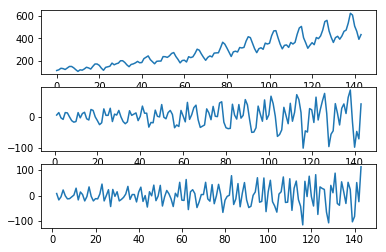

In [5]:
df["#Passengers_1d"] = df["#Passengers"] - df["#Passengers"].shift()
df["#Passengers_2d"] = df["#Passengers_1d"] - df["#Passengers_1d"].shift()
plt.subplot(311)
plt.plot(df["#Passengers"])
plt.subplot(312)
plt.plot(df["#Passengers_1d"])
plt.subplot(313)
plt.plot(df["#Passengers_2d"])
plt.show()

- 対数差分系列もよく使われる(底は$e$)
- $\Delta \log y_t=\log y_t-\log y_{t-1}$
- 対数変換をすると，足し算が掛け算に変わる
  - 時系列データ＝周期的変動＋トレンド＋ホワイトノイズ とすると<br>$\log$時系列データ＝$\log$周期的変動＋$\log$トレンド＋$\log$ホワイトノイズ<br>$\log$時系列データ＝$\log$(周期的変動\*トレンド\*ホワイトノイズ)

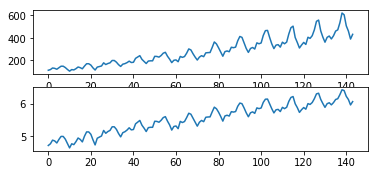

In [6]:
df["#Passengers_log"] = df["#Passengers"].apply(np.log)
plt.subplot(311)
plt.plot(df["#Passengers"])
plt.subplot(312)
plt.plot(df["#Passengers_log"])
plt.show()

- 季節階差は，「前年同期との差」
  - 「去年の1月と今年の1月の差」みたいなやつ

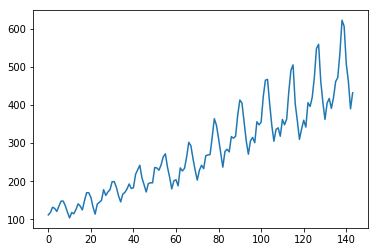

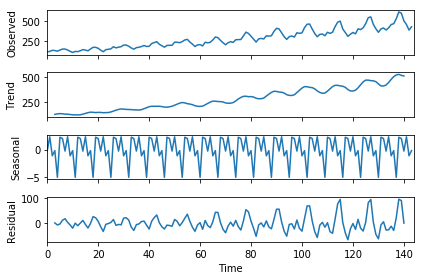

In [7]:
# 時系列データ＝短期の自己相関＋周期的変動＋トレンド＋外因性＋ホワイトノイズで表現される
# statsmodelsのseasonal_decomposeでは，時系列データ＝トレンド成分＋季節成分＋残差で表現される
# http://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html?highlight=seasonal
df["#Passengers"].plot()
res = sm.tsa.seasonal_decompose(df["#Passengers"].values, freq=7)  # 日時データだからとりあえず7日で季節性があるか
res.plot()
plt.show()

#### ランダムウォーク

$y_t=y_{t-1}+\epsilon_t, \, \epsilon_t \sim N(0, \sigma^2)$

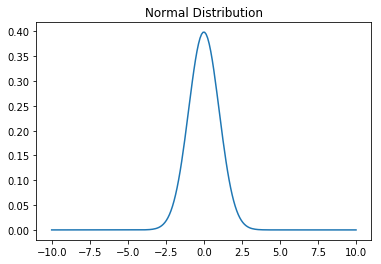

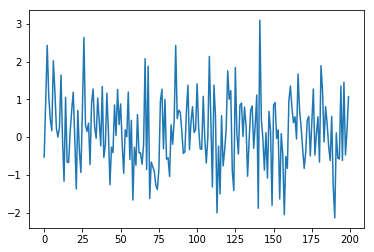

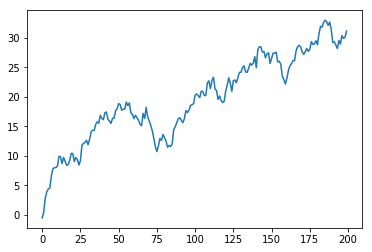

0.15579674271879754 0.9488800074008181
np.cumsumは累積和をとることができる
np.cumsum([1,2,3,4,5] -> [ 1  3  6 10 15]


In [8]:
x = np.linspace(-10, 10, 200)
epsilon = stats.norm.pdf(x, loc=0, scale=1.0)  # locが平均，scaleが標準偏差
plt.plot(x, epsilon)
plt.title("Normal Distribution")
plt.show()
 
# サンプリングはrvsを使って取得
xs = stats.norm.rvs(loc=0, scale=1.0, size=200)
plt.plot(xs)
plt.show()
plt.plot(np.cumsum(xs))
plt.show()
print(xs.mean(), xs.std())
print("np.cumsumは累積和をとることができる")
print(f"np.cumsum([1,2,3,4,5] -> {np.cumsum([1,2,3,4,5])}")

- 2段目，ホワイトノイズは定常過程
- 3段目，ランダムウォークは非定常過程
- ランダムウォークの1階差分がホワイトノイズで定常過程になる